In [66]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# === Parameters ===
n_total = 200_000
fraud_rate = 0.001
n_fraud = int(n_total * fraud_rate)
n_legit = n_total - n_fraud

# === Generate base timestamps ===
base_time = datetime.strptime("2024-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
def generate_datetimes(n):
    return [base_time + timedelta(seconds=int(np.random.uniform(0, 86400 * 30))) for _ in range(n)]

# === Legitimate Transactions ===
legit_data = {
    'TRANSACTION_ID': np.arange(n_legit),
    'TX_DATETIME': generate_datetimes(n_legit),

    'CUSTOMER_ID': np.random.randint(2000, 5000, size=n_legit),
    'TERMINAL_ID': np.random.randint(3000, 8000, size=n_legit),

    'TX_AMOUNT': np.round(np.random.uniform(1, 5000, size=n_legit), 2),

    'TX_TIME_SECONDS': np.random.randint(0, 20000, size=n_legit),        # Short duration
    'TX_TIME_DAYS': np.random.randint(0, 25, size=n_legit),
    'TX_FRAUD': np.zeros(n_legit, dtype=int),

    'TRIES': np.random.choice([0, 1, 2], p=[0.6, 0.3, 0.1], size=n_legit)  # Low attempts
}

# === Fraudulent Transactions ===
fraud_data = {
    'TRANSACTION_ID': np.arange(n_legit, n_total),
    'TX_DATETIME': generate_datetimes(n_fraud),

    'CUSTOMER_ID': np.random.randint(1000, 2000, size=n_fraud),           # Lower ID range
    'TERMINAL_ID': np.random.randint(1000, 4000, size=n_fraud),

    'TX_AMOUNT': np.round(np.random.uniform(5000, 25000, size=n_fraud), 2),  # Suspiciously large

    'TX_TIME_SECONDS': np.random.randint(30000, 86400, size=n_fraud),     # Long duration
    'TX_TIME_DAYS': np.random.randint(0, 30, size=n_fraud),
    'TX_FRAUD': np.ones(n_fraud, dtype=int),

    'TRIES': np.random.choice([3, 4, 5], p=[0.4, 0.4, 0.2], size=n_fraud)  # More attempts
}

# === Combine and Shuffle ===
df = pd.concat([pd.DataFrame(legit_data), pd.DataFrame(fraud_data)]).sample(frac=1).reset_index(drop=True)
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME']).dt.strftime('%Y-%m-%d %H:%M:%S')

# === Add Noise ===
# 1. Missing values
for col in ['TX_AMOUNT', 'TX_TIME_SECONDS', 'TRIES']:
    missing_idx = np.random.choice(df.index, size=int(0.002 * len(df)), replace=False)
    df.loc[missing_idx, col] = np.nan

# 2. Outliers in TX_AMOUNT
outlier_idx = np.random.choice(df.index, size=int(0.001 * len(df)), replace=False)
df.loc[outlier_idx, 'TX_AMOUNT'] = df['TX_AMOUNT'].max() * np.random.uniform(2, 4, size=len(outlier_idx))

# 3. CUSTOMER_ID skew for fraud
drift_idx = df[(df['TX_FRAUD'] == 1)].sample(frac=0.3).index
df.loc[drift_idx, 'CUSTOMER_ID'] = np.random.randint(1000, 1200, size=len(drift_idx))

# 4. Duplicate records
dupes = df.sample(n=500)
df = pd.concat([df, dupes], ignore_index=True)

# === Final Output ===
print(f"Total records: {len(df)}")
print(f"Frauds: {df['TX_FRAUD'].sum()}")
print(f"Fraud rate: {df['TX_FRAUD'].mean() * 100:.4f}%")
print(df.head())

# Optional: save
# df.to_csv("fraud_dataset.csv", index=False)


Total records: 200500
Frauds: 200
Fraud rate: 0.0998%
   TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  \
0          174692  2024-01-05 00:02:15         2569         5865    3987.79   
1           61482  2024-01-14 09:55:40         4339         5180     509.00   
2           17052  2024-01-27 19:10:13         4058         7998    4999.13   
3          181741  2024-01-28 00:14:57         3459         5724    4648.11   
4           78280  2024-01-07 21:09:10         4801         4269    1966.44   

   TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TRIES  
0          16393.0            11         0    1.0  
1           6643.0            19         0    0.0  
2          12501.0             3         0    2.0  
3           5002.0            18         0    2.0  
4          12723.0            12         0    1.0  


In [67]:
df.to_csv('payment_fraud.csv', index=False)

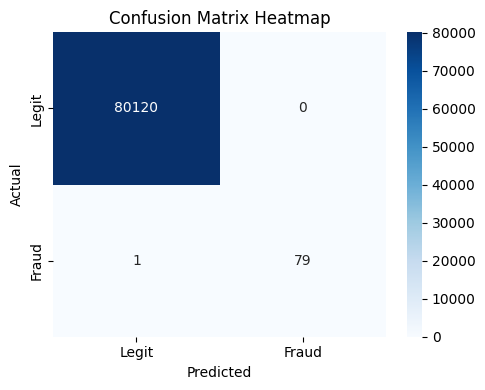

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Define features and target
features = ['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TRIES']
X = df[features].fillna(df[features].mean())
y = df['TX_FRAUD']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitx
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.4, random_state=42)

# Logistic Regression with class_weight
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()


In [69]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     80120
           1     1.0000    0.9875    0.9937        80

    accuracy                         1.0000     80200
   macro avg     1.0000    0.9938    0.9969     80200
weighted avg     1.0000    1.0000    1.0000     80200



In [70]:
import joblib

joblib.dump(model, 'fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [65]:
import pandas as pd
import joblib

# Load model and scaler
model = joblib.load('fraud_model.pkl')
scaler = joblib.load('scaler.pkl')

# === Tricky Test Cases ===
test_cases = [
    # 1. Very high amount but only 1 try and short duration — ambiguous
    {'TX_AMOUNT': 10000, 'TX_TIME_SECONDS': 1200, 'TX_TIME_DAYS': 3, 'TRIES': 1, },

    # 2. Low amount but many tries, suggesting suspicious behavior
    {'TX_AMOUNT': 300, 'TX_TIME_SECONDS': 1500, 'TX_TIME_DAYS': 10, 'TRIES': 5, },

    # 3. Mid-range everything but CUSTOMER_ID is in fraudulent range000, 'TX_TIME_DAYS': 17, 'TRIES': 2, 

    # 4. Low tries, low time, high amount — potential legit VIP?
    {'TX_AMOUNT': 15000, 'TX_TIME_SECONDS': 100, 'TX_TIME_DAYS': 2, 'TRIES': 0, },

    # 5. Low everything except abnormal time usage (suspicious)
    {'TX_AMOUNT': 400, 'TX_TIME_SECONDS': 84000, 'TX_TIME_DAYS': 5, 'TRIES': 1, },

    # 6. Very low amount + high time + 0 tries — could look like human error or test?
    {'TX_AMOUNT': 50, 'TX_TIME_SECONDS': 86399, 'TX_TIME_DAYS': 1, 'TRIES': 0},

    # 7. High amount + high time + high tries — triple flag
    {'TX_AMOUNT': 18000, 'TX_TIME_SECONDS': 85000, 'TX_TIME_DAYS': 29, 'TRIES': 5},

    # 8. Medium amount + midnight time (suspicious time) + 3 tries
    {'TX_AMOUNT': 3000, 'TX_TIME_SECONDS': 60, 'TX_TIME_DAYS': 17, 'TRIES': 3},

    # 9. Legit-appearing low amount, but too many tries (bot retrying?)
    {'TX_AMOUNT': 480, 'TX_TIME_SECONDS': 2000, 'TX_TIME_DAYS': 5, 'TRIES': 7},

    # 10. Borderline amount, average time, low tries — hard to classify
    {'TX_AMOUNT': 4999, 'TX_TIME_SECONDS': 43200, 'TX_TIME_DAYS': 15, 'TRIES': 1},

    # 11. Sudden surge transaction — high amount, 0 tries, and early day
    {'TX_AMOUNT': 10000, 'TX_TIME_SECONDS': 300, 'TX_TIME_DAYS': 0, 'TRIES': 0},

    # 12. Flat profile — everything is average-ish
    {'TX_AMOUNT': 2500, 'TX_TIME_SECONDS': 43000, 'TX_TIME_DAYS': 13, 'TRIES': 2},

    # 13. Repeated attempts in late hours — odd signature
    {'TX_AMOUNT': 950, 'TX_TIME_SECONDS': 85500, 'TX_TIME_DAYS': 12, 'TRIES': 6},

    # 14. Legit profile, but strange combo — low amount, long day, 1 try
    {'TX_AMOUNT': 120, 'TX_TIME_SECONDS': 3600, 'TX_TIME_DAYS': 28, 'TRIES': 1},

    # 15. High frequency low-value attacker? — fast, many tries, low amount
    {'TX_AMOUNT': 60, 'TX_TIME_SECONDS': 100, 'TX_TIME_DAYS': 10, 'TRIES': 10},
]

# Convert to DataFrame
custom_df = pd.DataFrame(test_cases)

# Preprocess
X_custom = scaler.transform(custom_df)

# Predict
preds = model.predict(X_custom)
probas = model.predict_proba(X_custom)[:, 1]

# Display results
for i, (row, pred, prob) in enumerate(zip(test_cases, preds, probas), 1):
    print(f"\nTest Case {i}:")
    print(row)
    print(f"→ Prediction: {'FRAUD' if pred else 'LEGIT'} | Probability of Fraud: {prob:.4f}")



Test Case 1:
{'TX_AMOUNT': 10000, 'TX_TIME_SECONDS': 1200, 'TX_TIME_DAYS': 3, 'TRIES': 1}
→ Prediction: LEGIT | Probability of Fraud: 0.1900

Test Case 2:
{'TX_AMOUNT': 300, 'TX_TIME_SECONDS': 1500, 'TX_TIME_DAYS': 10, 'TRIES': 5}
→ Prediction: LEGIT | Probability of Fraud: 0.4400

Test Case 3:
{'TX_AMOUNT': 15000, 'TX_TIME_SECONDS': 100, 'TX_TIME_DAYS': 2, 'TRIES': 0}
→ Prediction: LEGIT | Probability of Fraud: 0.2100

Test Case 4:
{'TX_AMOUNT': 400, 'TX_TIME_SECONDS': 84000, 'TX_TIME_DAYS': 5, 'TRIES': 1}
→ Prediction: FRAUD | Probability of Fraud: 0.7300

Test Case 5:
{'TX_AMOUNT': 50, 'TX_TIME_SECONDS': 86399, 'TX_TIME_DAYS': 1, 'TRIES': 0}
→ Prediction: FRAUD | Probability of Fraud: 0.7300

Test Case 6:
{'TX_AMOUNT': 18000, 'TX_TIME_SECONDS': 85000, 'TX_TIME_DAYS': 29, 'TRIES': 5}
→ Prediction: FRAUD | Probability of Fraud: 1.0000

Test Case 7:
{'TX_AMOUNT': 3000, 'TX_TIME_SECONDS': 60, 'TX_TIME_DAYS': 17, 'TRIES': 3}
→ Prediction: LEGIT | Probability of Fraud: 0.4500

Test Case 

In [45]:
# DataFrame `df` already contains full dataset

df_fraud = df[df['TX_FRAUD'] == 1]
df_nonfraud = df[df['TX_FRAUD'] == 0]

# Keep all frauds + sample of non-fraud to maintain good recall and training signal
df_nonfraud_sampled = df_nonfraud.sample(frac=0.2, random_state=42)  # use 20% legit
df_train = pd.concat([df_fraud, df_nonfraud_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']
X = df_train[features]
y = df_train['TX_FRAUD']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.25, random_state=42)


In [95]:
from xgboost import XGBClassifier

# Use scale_pos_weight = (#nonfraud / #fraud)
neg, pos = y_train.value_counts()
scale = neg / pos

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',

    max_depth=6,
    learning_rate=0.05,
    n_estimators=10
)

model.fit(X_train, y_train)


c:\Users\RISHI RAMAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:53:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, ...)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


[[79760    55]
 [  267 39201]]
              precision    recall  f1-score   support

           0     0.9967    0.9993    0.9980     79815
           1     0.9986    0.9932    0.9959     39468

    accuracy                         0.9973    119283
   macro avg     0.9976    0.9963    0.9969    119283
weighted avg     0.9973    0.9973    0.9973    119283

ROC AUC: 0.9999361201086523


In [97]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
fscore = 2 * precision * recall / (precision + recall)
ix = np.argmax(fscore)
best_thresh = thresholds[ix]

print(f'Best Threshold: {best_thresh:.3f} | F1: {fscore[ix]:.4f} | Recall: {recall[ix]:.4f} | Precision: {precision[ix]:.4f}')

# Apply new threshold
y_pred_adj = (y_prob >= best_thresh).astype(int)
print(confusion_matrix(y_test, y_pred_adj))
print(classification_report(y_test, y_pred_adj, digits=4))


Best Threshold: 0.379 | F1: 0.9978 | Recall: 1.0000 | Precision: 0.9956
[[79641   174]
 [    0 39468]]
              precision    recall  f1-score   support

           0     1.0000    0.9978    0.9989     79815
           1     0.9956    1.0000    0.9978     39468

    accuracy                         0.9985    119283
   macro avg     0.9978    0.9989    0.9984    119283
weighted avg     0.9985    0.9985    0.9985    119283



C:\Users\RISHI RAMAN\AppData\Local\Temp\ipykernel_8708\1685940983.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TX_FRAUD', data=df, palette='Set2')


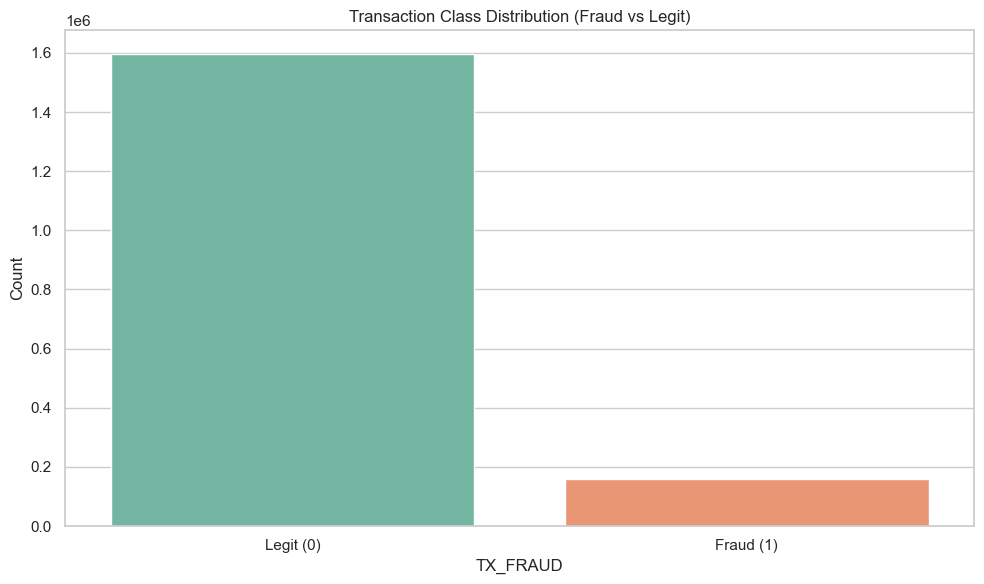

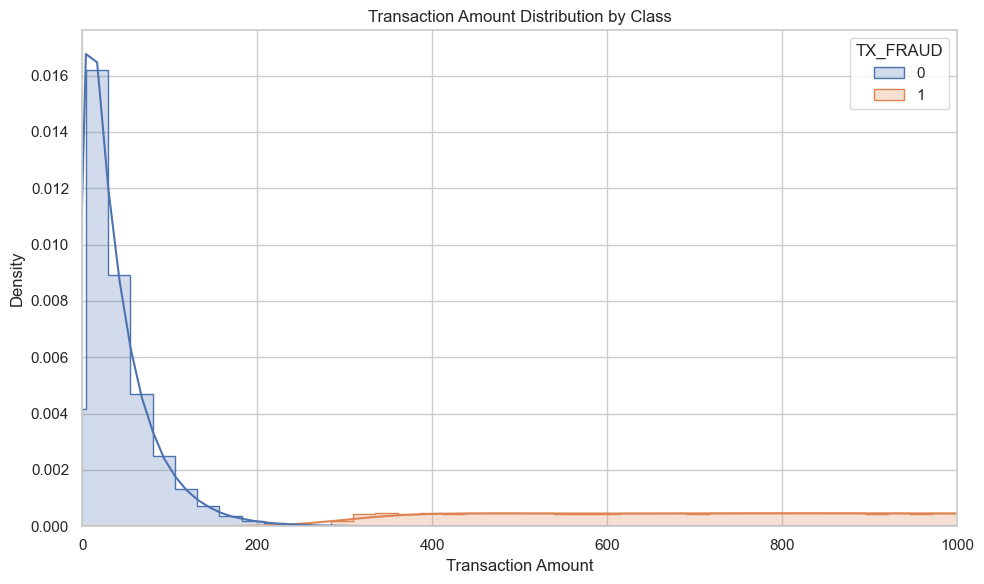

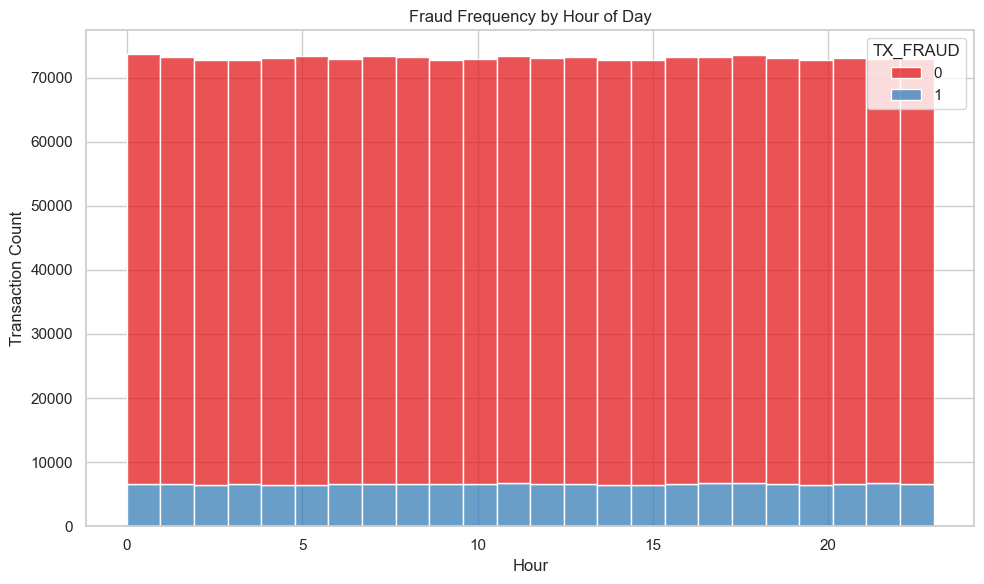

C:\Users\RISHI RAMAN\AppData\Local\Temp\ipykernel_8708\1685940983.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['TX_FRAUD'] == 1], x='TX_FRAUD_SCENARIO', palette='pastel')


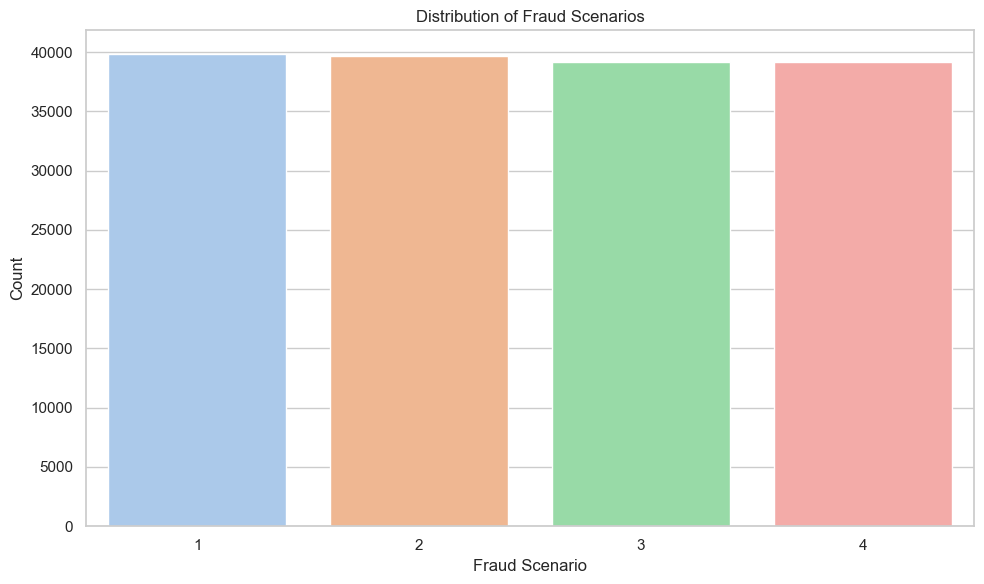

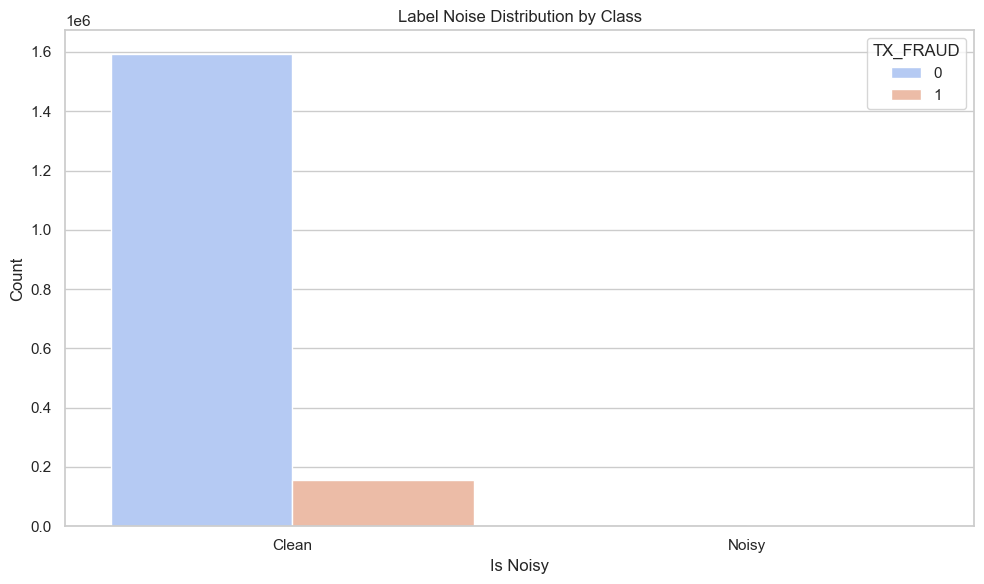

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# === 1. Fraud vs Legit Count ===
plt.figure()
sns.countplot(x='TX_FRAUD', data=df, palette='Set2')
plt.title('Transaction Class Distribution (Fraud vs Legit)')
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.ylabel('Count')
plt.xlabel('TX_FRAUD')
plt.tight_layout()
plt.show()

# === 2. Transaction Amount Distribution by Class ===
plt.figure()
sns.histplot(data=df, x='TX_AMOUNT', hue='TX_FRAUD', bins=100, kde=True, element='step', stat='density', common_norm=False)
plt.title('Transaction Amount Distribution by Class')
plt.xlim(0, 1000)  # focus on non-outlier range
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# === 3. Fraud by Time of Day ===
df['TX_HOUR'] = pd.to_datetime(df['TX_DATETIME']).dt.hour
plt.figure()
sns.histplot(data=df, x='TX_HOUR', bins=24, hue='TX_FRAUD', multiple='stack', palette='Set1')
plt.title('Fraud Frequency by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.tight_layout()
plt.show()

# === 4. Fraud Scenarios Breakdown ===
plt.figure()
sns.countplot(data=df[df['TX_FRAUD'] == 1], x='TX_FRAUD_SCENARIO', palette='pastel')
plt.title('Distribution of Fraud Scenarios')
plt.xlabel('Fraud Scenario')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# === 5. Noisy Label Visualization (Optional) ===
# === Add Label Noise ===
flip_idx = df.sample(frac=label_noise_rate, random_state=42).index
df.loc[flip_idx, 'TX_FRAUD'] = 1 - df.loc[flip_idx, 'TX_FRAUD']

# Fix TX_FRAUD_SCENARIO
fraud_flips = df.loc[flip_idx].query("TX_FRAUD == 1").index
legit_flips = df.loc[flip_idx].query("TX_FRAUD == 0").index
df.loc[fraud_flips, 'TX_FRAUD_SCENARIO'] = np.random.randint(1, 5, size=len(fraud_flips))
df.loc[legit_flips, 'TX_FRAUD_SCENARIO'] = 0

# ✅ Add this — was likely missing
df['IS_NOISY'] = 0
df.loc[flip_idx, 'IS_NOISY'] = 1

plt.figure()
sns.countplot(data=df, x='IS_NOISY', hue='TX_FRAUD', palette='coolwarm')
plt.title('Label Noise Distribution by Class')
plt.xlabel('Is Noisy')
plt.ylabel('Count')
plt.xticks([0, 1], ['Clean', 'Noisy'])
plt.tight_layout()
plt.show()
